# ADA Price Prediction using SARIMAX

## 1. Sourcing and Loading

### Load relevant librarie

In [1]:
#!pip install fredapi
#!pip install load_dotenv

In [84]:
#File and name management libraries
import os
import shutil

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import matplotlib.dates as mdates
from datetime import datetime, timedelta

#API
import requests


#Finance Data
import yfinance as yf


### Load the data

In [194]:
# Get dates
START_DATE = "2018-01-01"
print(f"Start date: {START_DATE}")

TODAY = datetime.today().date()
print(f"Current date: {TODAY}")

NUM_STEPS = 10

Start date: 2018-01-01
Current date: 2024-03-17


In [4]:
TARGET_FEATURE = 'CARDANO'

### Read data

In [5]:
# Define the symbols for the data you want to download from CoinGecko
coingecko_symbols = ['bitcoin', 'ethereum', 'cardano']

# Define the start and end dates
plot_start_index = START_DATE
end_date = TODAY  

# Convert the start date to a datetime.date object
plot_start_index = datetime.strptime(plot_start_index, '%Y-%m-%d').date()

# Calculate the number of days between the start and end dates
days = (end_date - plot_start_index).days

# Initialize an empty DataFrame to store the data
df_crypto = pd.DataFrame()

# Iterate over the CoinGecko symbols
for symbol in coingecko_symbols:
    # Define the CoinGecko API URL for the symbol's market chart
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"

    # Define the parameters for the GET request
    params = {
        'vs_currency': 'usd',
        'days': days
    }

    # Send a GET request to the CoinGecko API
    response = requests.get(url, params=params)

    # Convert the response to JSON
    crypto_data = response.json()

    # Convert the prices data to a DataFrame
    crypto_df = pd.DataFrame(crypto_data['prices'], columns=['time', symbol])

    # Convert the time column to datetime
    crypto_df['time'] = pd.to_datetime(crypto_df['time'], unit='ms')

    # Set the time column as the index
    crypto_df.set_index('time', inplace=True)

    # Rename the symbol column to the symbol name
    crypto_df.rename(columns={symbol: symbol.upper()}, inplace=True)

    # If the data DataFrame is empty, copy the crypto_df DataFrame
    if df_crypto.empty:
        df_crypto = crypto_df.copy()
    else:
        # Otherwise, join the crypto_df DataFrame to the data DataFrame
        df_crypto = df_crypto.join(crypto_df)

In [8]:
'''# Fetch the Bitcoin dominance rate for each day in the date range
btc_dominance_list = []
for day in range(days):
    date = start_date + timedelta(days=day)
    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&ids=bitcoin"
    response = requests.get(url)
    btc_data = response.json()
    btc_market_cap = btc_data[0]['market_cap']

    url = "https://api.coingecko.com/api/v3/global"
    response = requests.get(url)
    global_data = response.json()
    total_market_cap = global_data['data']['total_market_cap']['usd']

    btc_dominance = (btc_market_cap / total_market_cap) * 100
    btc_dominance_list.append(btc_dominance)

# Add the Bitcoin dominance rate to the DataFrame
df_crypto['BTC_Dominance'] = btc_dominance_list'''

'# Fetch the Bitcoin dominance rate for each day in the date range\nbtc_dominance_list = []\nfor day in range(days):\n    date = start_date + timedelta(days=day)\n    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&ids=bitcoin"\n    response = requests.get(url)\n    btc_data = response.json()\n    btc_market_cap = btc_data[0][\'market_cap\']\n\n    url = "https://api.coingecko.com/api/v3/global"\n    response = requests.get(url)\n    global_data = response.json()\n    total_market_cap = global_data[\'data\'][\'total_market_cap\'][\'usd\']\n\n    btc_dominance = (btc_market_cap / total_market_cap) * 100\n    btc_dominance_list.append(btc_dominance)\n\n# Add the Bitcoin dominance rate to the DataFrame\ndf_crypto[\'BTC_Dominance\'] = btc_dominance_list'

In [9]:
# Display the DataFrame
display(df_crypto.tail())

,BITCOIN,ETHEREUM,CARDANO
time,,,
2024-03-15 00:00:00,71420.031801,3879.038367,0.750550
2024-03-16 00:00:00,69497.763193,3738.381184,0.727011
2024-03-17 00:00:00,65292.313293,3514.222472,0.658237
2024-03-18 00:00:00,68425.415656,3643.280347,NaN
2024-03-18 01:54:23,67693.039334,NaN,NaN


#### Financial Indexes

In [10]:
#Define the symbols for the data_modeled you want to download from yfinance
yfinance_symbols = ['^IXIC', '^DJI', '^GSPC', 'GC=F', 'DX-Y.NYB']

# Download stock data_modeled from yfinance and save into DataFrame
data_yfinance = yf.download(yfinance_symbols, start=START_DATE, end=TODAY)['Adj Close']

data_yfinance.columns = ['NASDAQ', 'DOW', 'SP500', 'GOLD', 'USD_IDX']
display(data_yfinance.tail())


[*********************100%%**********************]  5 of 5 completed


,NASDAQ,DOW,SP500,GOLD,USD_IDX
Date,,,,,
2024-03-11,102.870003,2182.500000,38769.660156,5117.939941,16019.269531
2024-03-12,102.959999,2160.399902,39005.488281,5175.270020,16265.639648
2024-03-13,102.790001,2175.399902,39043.320312,5165.310059,16177.769531
2024-03-14,103.360001,2163.000000,38905.660156,5150.479980,16128.530273
2024-03-15,103.430000,2157.300049,38714.769531,5117.089844,15973.169922


## 2. Data preperation

## 2. Cleaning, transforming and visualizing

In [11]:
#reset index
df1 = df_crypto.reset_index()
df2 = data_yfinance.reset_index()

# Convert 'time' in df1 to date format (remove time)
df1['time'] = pd.to_datetime(df1['time']).dt.date

# Convert 'date' in df2 to date format
df2['Date'] = pd.to_datetime(df2['Date']).dt.date

# Now you can merge on 'time' and 'date'
merged_df = pd.merge(df1, df2, left_on='time', right_on='Date').drop('time', axis = 1)
merged_df.set_index('Date', inplace= True)
merged_df = merged_df.asfreq('D')  # Set the frequency to daily

In [12]:
# Resample the data for weekly average
# For a weekly frequency, ‘W’ or ‘W-SUN’, this means that the week is considered to start on Sunday
weekly_df = merged_df.resample('W-SUN').mean()


In [13]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

In [14]:
count_missing(weekly_df)

,count,%


In [15]:
df = weekly_df.copy()

In [16]:
#Handle missing values
df.dropna(subset = [TARGET_FEATURE], axis = 0, inplace = True)

# Assuming 'merged_df' is your DataFrame
df.fillna(method='ffill', inplace=True)

In [17]:
count_missing(df)

,count,%


In [188]:
display(df.tail(12).round(2))

,BITCOIN,ETHEREUM,CARDANO,NASDAQ,DOW,SP500,GOLD,USD_IDX
Date,,,,,,,,
2023-12-31,43043.45,2306.64,0.62,101.26,2069.10,37650.37,4777.38,15070.06
2024-01-07,44045.12,2298.24,0.59,102.37,2045.82,37512.92,4708.39,14598.13
2024-01-14,45974.51,2420.01,0.54,102.37,2027.14,37641.58,4773.51,14922.82
2024-01-21,42427.65,2525.12,0.52,103.41,2018.42,37490.05,4781.48,15041.65
2024-01-28,40188.41,2292.16,0.48,103.45,2018.22,37974.44,4873.74,15446.80
2024-02-04,42767.71,2299.97,0.51,103.45,2038.84,38425.06,4912.67,15458.51
2024-02-11,43584.26,2361.31,0.50,104.18,2030.18,38595.37,4983.32,15749.54
2024-02-18,50344.11,2682.36,0.57,104.49,2003.00,38579.10,5002.19,15827.82
2024-02-25,51870.37,2957.06,0.61,104.05,2024.74,38844.17,5033.28,15812.52


## Modeling

In [196]:
print(f"Start date: {START_DATE}")
print(f"Current date: {TODAY}")

Start date: 2018-01-01
Current date: 2024-03-17


### Making a predictor variable `y`

In [293]:
y = df[TARGET_FEATURE]
X = df.drop(columns=[TARGET_FEATURE])

In [295]:
#train data
y_train = y[:-NUM_STEPS]
X_train = X[:-NUM_STEPS]

#test data
y = y[-NUM_STEPS:]
X_test = X[-NUM_STEPS:]

In [298]:
display(y_train.tail(5).round(2))

Date
2023-12-10    0.43
2023-12-17    0.61
2023-12-24    0.60
2023-12-31    0.62
2024-01-07    0.59
Freq: W-SUN, Name: CARDANO, dtype: float64

In [299]:
display(X_train.tail(5).round(2))

,BITCOIN,ETHEREUM,NASDAQ,DOW,SP500,GOLD,USD_IDX
Date,,,,,,,
2023-12-10,42619.79,2262.83,103.88,2020.26,36149.74,4575.25,14261.21
2023-12-17,42470.22,2270.63,103.07,1997.88,36925.32,4682.39,14655.07
2023-12-24,42765.81,2205.58,102.13,2039.08,37347.25,4741.73,14928.56
2023-12-31,43043.45,2306.64,101.26,2069.10,37650.37,4777.38,15070.06
2024-01-07,44045.12,2298.24,102.37,2045.82,37512.92,4708.39,14598.13


### Getting summary statistics for `y`

In [217]:
df.describe().round(2)

,BITCOIN,ETHEREUM,CARDANO,NASDAQ,DOW,SP500,GOLD,USD_IDX
count,324.00,324.00,324.00,324.00,324.00,324.00,324.00,324.00
mean,22716.18,1307.35,0.48,97.98,1675.27,30178.41,3633.35,11010.04
std,16689.03,1148.24,0.57,5.34,264.23,4369.44,723.69,2848.23
min,3419.18,89.31,0.03,89.10,1182.90,20117.20,2405.55,6477.82
25%,8506.53,235.42,0.08,93.80,1419.75,26034.40,2896.34,7974.66
50%,18709.24,1165.06,0.28,97.13,1772.53,30474.42,3749.23,11231.77
75%,35076.39,1909.77,0.56,102.37,1886.24,33999.23,4271.67,13572.66
max,71438.24,4711.63,2.84,113.07,2167.72,39014.89,5145.22,16112.88


In [218]:
y_train.describe().round(2)

count    314.00
mean       0.47
std        0.58
min        0.03
25%        0.08
50%        0.27
75%        0.53
max        2.84
Name: CARDANO, dtype: float64

In [219]:
X_train.describe().round(2)

,BITCOIN,ETHEREUM,NASDAQ,DOW,SP500,GOLD,USD_IDX
count,314.00,314.00,314.00,314.00,314.00,314.00,314.00
mean,21809.88,1258.44,97.80,1663.27,29915.93,3590.74,10862.13
std,16046.25,1127.99,5.33,259.37,4177.84,693.49,2766.81
min,3419.18,89.31,89.10,1182.90,20117.20,2405.55,6477.82
25%,8253.69,227.37,93.57,1405.77,26025.03,2891.84,7965.46
50%,17129.59,1109.93,97.04,1762.97,30105.59,3694.42,11178.06
75%,32766.77,1869.78,101.90,1875.08,33933.07,4213.26,13397.58
max,65596.46,4711.63,113.07,2069.10,37650.37,4783.10,15960.09


### Plot `y`

In [224]:
def plotter(y):
    fig, ax = plt.subplots(figsize=(9, 4))
    # Check if 'y' is a DataFrame
    if isinstance(y, pd.DataFrame):
        for column in y.columns:
            plt.plot(y.index, y[column], label=column)
    else:
        plt.plot(y.index, y, label=y.name if hasattr(y, 'name') else None)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside plot frame
    plt.show()


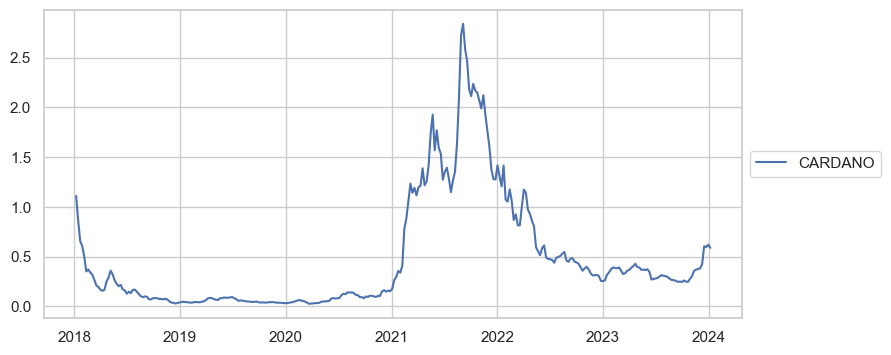

In [225]:
plotter(y_train)

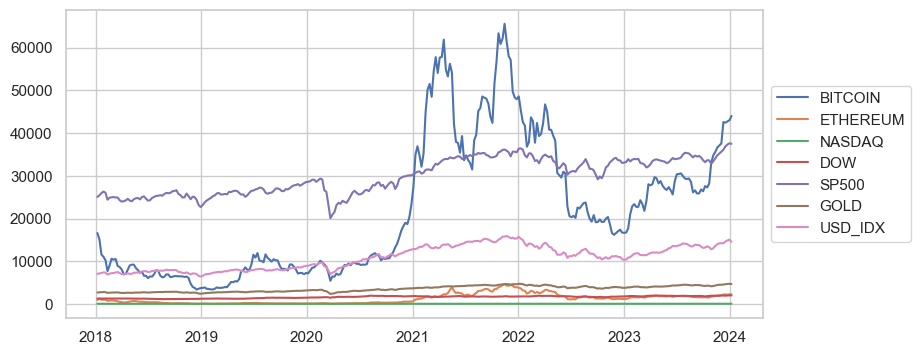

In [226]:
plotter(X_train)

## 3. Modeling

### Decomposition

In [229]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(data, step=None):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(data, model='multiplicative', period=step)

    # Extract the trend, seasonal, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original data, trend, seasonal, and residuals
    plt.figure(figsize=(9, 9))

    # Original data
    plt.subplot(411)
    plt.plot(data, label='Original Data')
    plt.legend(loc='best')

    # Trend component
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    # Seasonal component
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')

    # Residual component
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

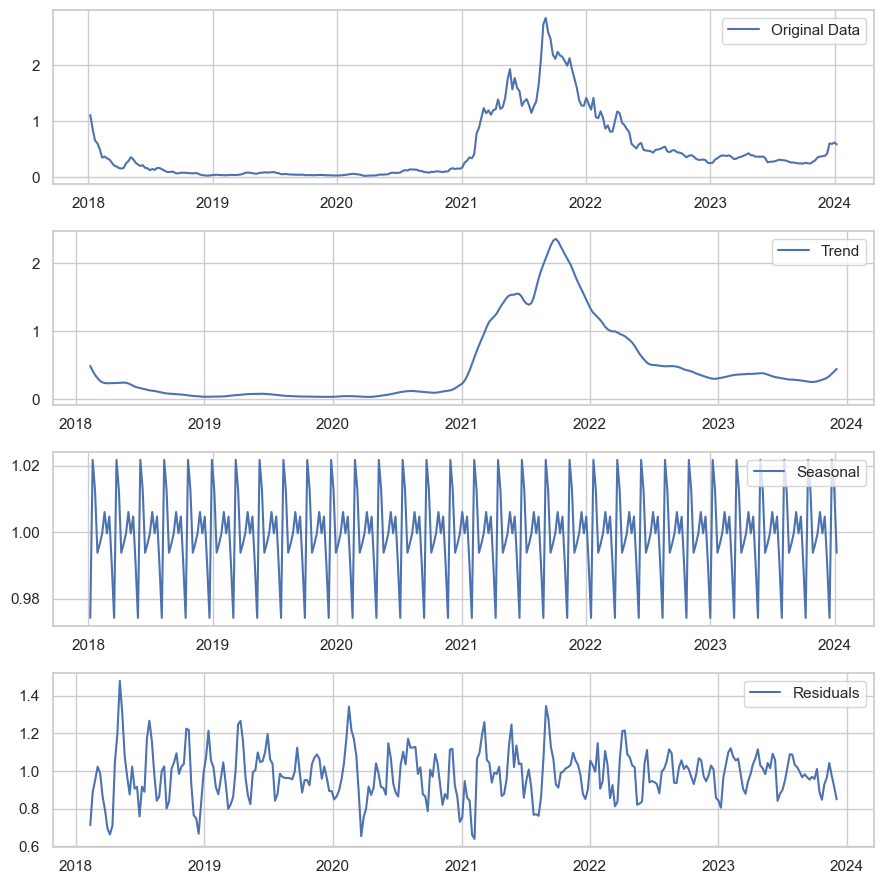

In [234]:
# Call the function
plot_seasonal_decomposition(y_train, NUM_STEPS)

### Testing For Stationarity

In [235]:
from statsmodels.tsa.stattools import adfuller


def adfuller_test(time_series, p_val):
    print('Augmented Dickey-Fuller Test')
    print('Hypotheses: H0 (non-stationary) | Ha (stationary)')
    print('---------------------------')
    
    result = adfuller(time_series)
    labels = ['ADF Statistic', 'p-value', 'Number of Lags', 'Number of Observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
        
    print('---------------------------')    
    if result[1] <= p_val:
        print("Conclusion: Strong evidence against the null hypothesis (H0).")
        print("Reject the null hypothesis. The data has no unit root and is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis.")
        print("The time series has a unit root, indicating it is non-stationary.")

In [236]:
adfuller_test(y_train, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -1.8839831722357514
p-value: 0.33963303779786064
Number of Lags: 1
Number of Observations: 312
---------------------------
Conclusion: Weak evidence against the null hypothesis.
The time series has a unit root, indicating it is non-stationary.


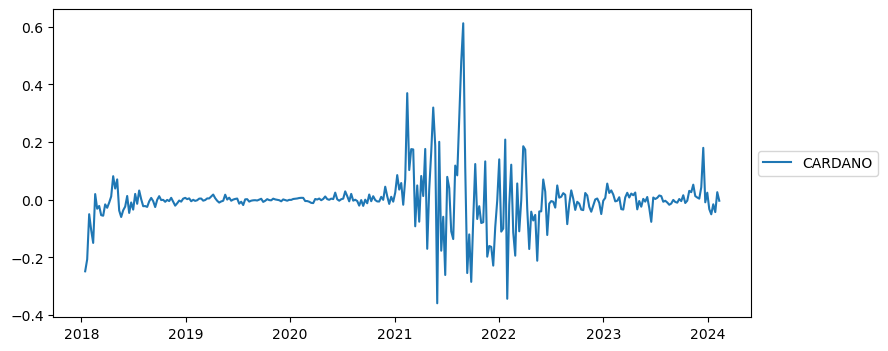

In [72]:
y_train_diff = y_train.diff().dropna()
plotter(y_train_diff)

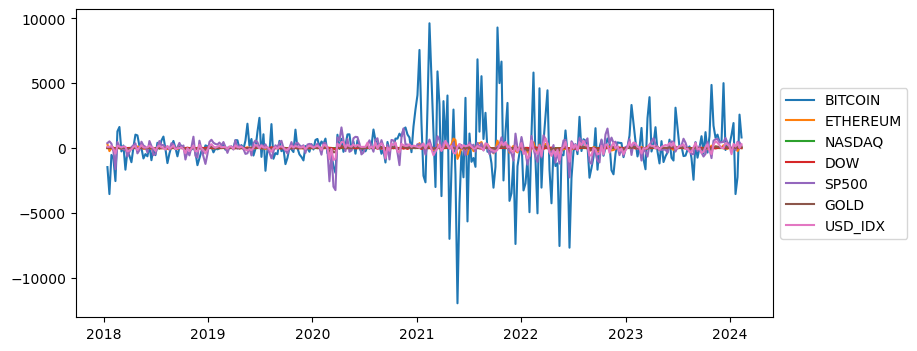

In [70]:
X_train_diff = X_train.diff().dropna()
plotter(X_train_diff)

In [73]:
adfuller_test(y_train_diff, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -13.428658687269445
p-value: 4.0544484772873797e-25
Number of Lags: 0
Number of Observations: 317
---------------------------
Conclusion: Strong evidence against the null hypothesis (H0).
Reject the null hypothesis. The data has no unit root and is stationary.


### ACF & PACF Plots

In [237]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time_series, max_lags=50):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot the ACF
    plot_acf(time_series, lags=max_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # Plot the PACF
    plot_pacf(time_series, lags=max_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

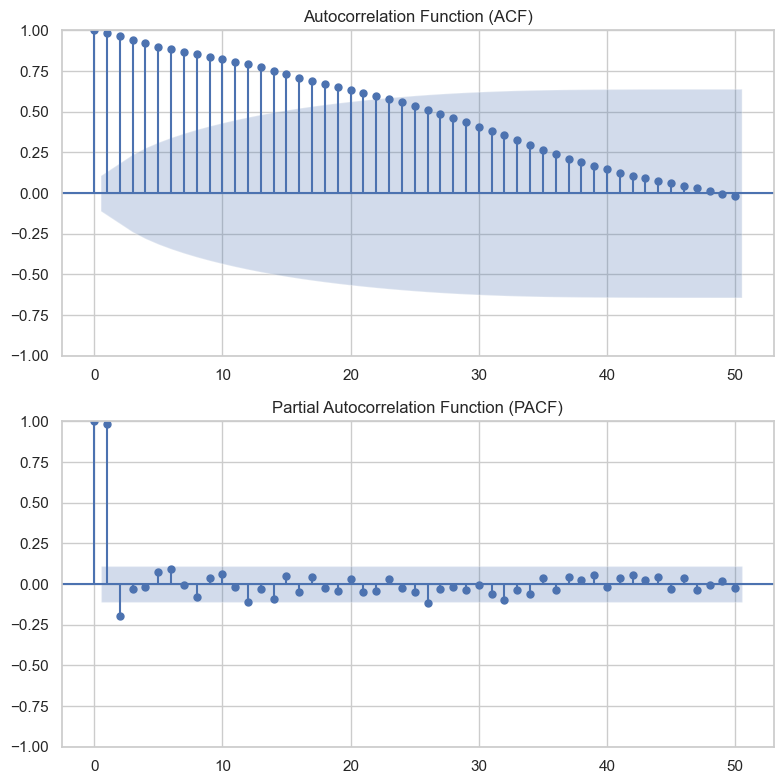

In [238]:
plot_acf_pacf(y_train,50)

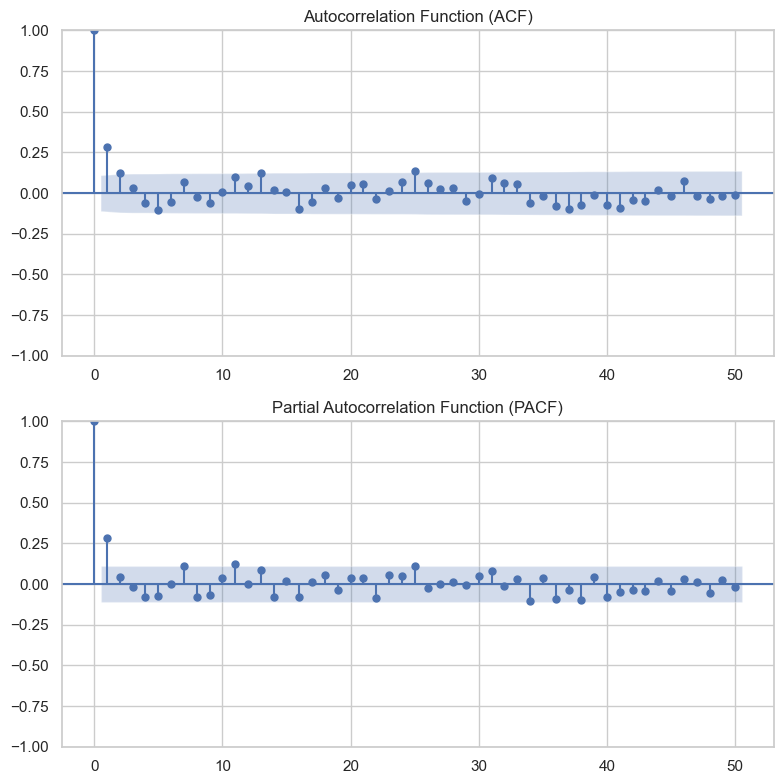

In [239]:
plot_acf_pacf(y_train_diff,50)

### The SARIMAX model


In [240]:
import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [241]:
def find_best_sarimax_params(data, features, max_ar=2, max_ma=2, max_s=2):
    """
    Finds the best SARIMAX parameters (p, d, q, P, D, Q, s) based on AIC.
    
    Args:
        data (pd.Series): Target time series data.
        features (pd.DataFrame): Exogenous features.
        max_ar (int): Maximum AR order.
        max_ma (int): Maximum MA order.
        max_s (int): Maximum seasonal order.
    
    Returns:
        Tuple: Best SARIMAX parameters (p, d, q, P, D, Q, s).
    """
    p = d = range(0, max_ar+1)
    q = range(0, max_ma+1)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq for s in range(0, max_s+1)]

    best_aic = np.inf
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.SARIMAX(data,
                                      exog=features,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
                results = model.fit()

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue

    return best_params


### Find the best SARIMA params

In [92]:
best_params = find_best_sarimax_params(y_train, X_train)
print('Best ARIMA params:', best_params[0])
print('Best seasonal params:', best_params[1])

Best ARIMA params: (1, 1, 0)
Best seasonal params: (0, 0, 0, 0)


### Fit SARIMA model

In [93]:
# specify the model
model_train = SARIMAX(y_train,
                exog = X_train,
                order=best_params[0],            # specify your ARIMA order
                seasonal_order=best_params[1],   # specify your seasonal order
                enforce_stationarity=False,      # depending on your data you might want to change these
                enforce_invertibility=False)

# fit the model
model_fit = model_train.fit()

# get a summary of the model parameters and performance
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                CARDANO   No. Observations:                  319
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 388.614
Date:                Sun, 17 Mar 2024   AIC                           -759.228
Time:                        22:33:09   BIC                           -725.398
Sample:                    01-07-2018   HQIC                          -745.714
                         - 02-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BITCOIN     9.668e-06   1.88e-06      5.134      0.000    5.98e-06    1.34e-05
ETHEREUM       0.0002    2.4e-05      7.258      0.000       0.000       0.000
NASDAQ        -0.0016      0.011     -0.145      0.8

## 4. Predict

In [251]:
def plot_predict(model, train_data, steps = 1, start_date=None):
    # forecast for the next 'steps' periods
    predict = model.get_prediction(start=PLOT_START_INDEX, steps = steps, dynamic=False)


    # If a start date is provided, slice the data
    if start_date:
        train_data = train_data[PLOT_START_INDEX:]

    # set seaborn style
    sns.set(style='whitegrid')

    # set the figure size
    plt.figure(figsize=(16, 6))

    # plot the time series data
    sns.lineplot(data=train_data, color='k', label='Observed')

    # plot your mean predictions
    sns.lineplot(x=predict.predicted_mean.index, y=predict.predicted_mean, color='b', linestyle = 'dashed' , label='Predicted')

    plt.title('SARIMAX model prediction for next {} steps'.format(steps))
    plt.xlabel('Date')
    plt.ylabel('Values')
    

    plt.legend()
    plt.show()


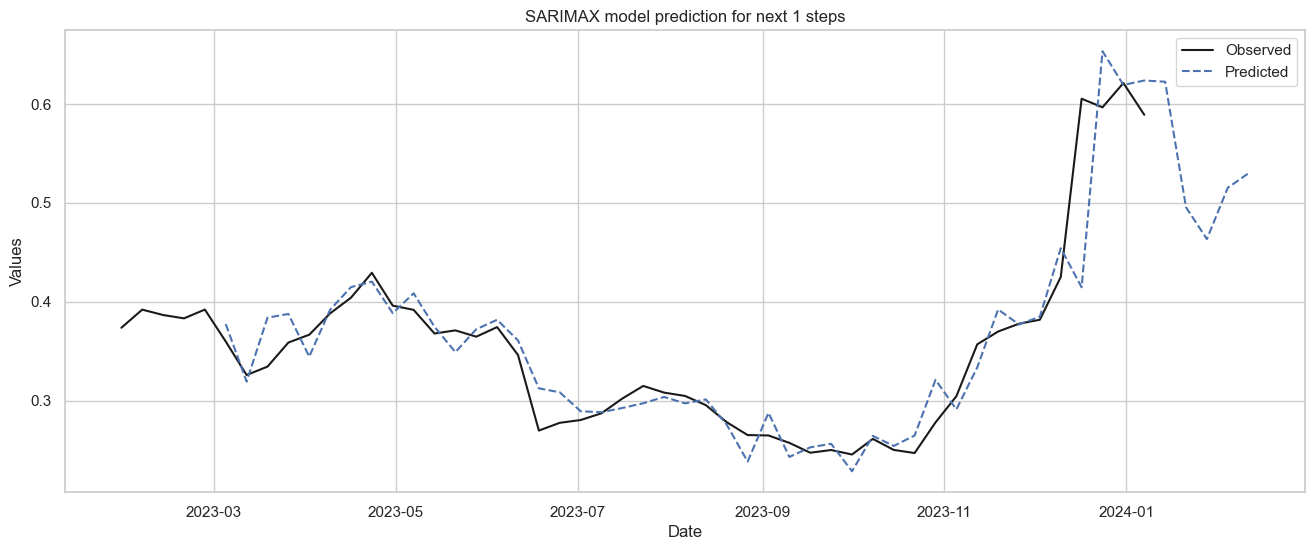

In [359]:
PLOT_START_INDEX = -50
plot_predict(model_fit, y_train, start_date = PLOT_START_INDEX)

In [344]:
y_train

Date
2018-01-07    1.110856
2018-01-14    0.862867
2018-01-21    0.656223
2018-01-28    0.606264
2018-02-04    0.501392
                ...   
2023-12-10    0.425003
2023-12-17    0.605196
2023-12-24    0.596486
2023-12-31    0.621075
2024-01-07    0.588933
Freq: W-SUN, Name: CARDANO, Length: 314, dtype: float64

In [373]:
def plot_forecast(model, y_train, y, X, n_steps=NUM_STEPS, plot_start_index = PLOT_START_INDEX):

    print(y.index[-NUM_STEPS])

    # forecast for the next 'steps' periods
    forecast = model.get_forecast(steps=n_steps, exog=X[-n_steps:])

    # Get the confidence intervals of the predictions
    forecast_ci = forecast.conf_int()

    # If a start date is provided, slice the data
    if plot_start_index:
        y_train = y_train[plot_start_index:]
        y = y[plot_start_index:]


    # set seaborn style
    sns.set(style='whitegrid')

    # set the figure size
    plt.figure(figsize=(16, 6))

    # plot the time series data
    sns.lineplot(data=y[:-n_steps+1], color='k', label='Historical')
    sns.lineplot(data=y[-n_steps:], color='k', linestyle = 'dotted', label='Actual')

    # plot your mean predictions
    sns.lineplot(x=forecast.predicted_mean.index, y=forecast.predicted_mean, color='b', label='Predict')

    # shade the area between your confidence limits
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 0], color='r', alpha=0.1)
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 1], color='r', alpha=0.1)
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='b', alpha=0.1)

    plt.title('SARIMA model forecast for next {} periods'.format(n_steps))
    plt.xlabel('Date')
    plt.ylabel('Values')
    
    plt.axvline(x=y.index[-n_steps], c='gray', linewidth = 2.5, ls='--', alpha=0.8)

    plt.legend()
    plt.show()


2024-01-14 00:00:00


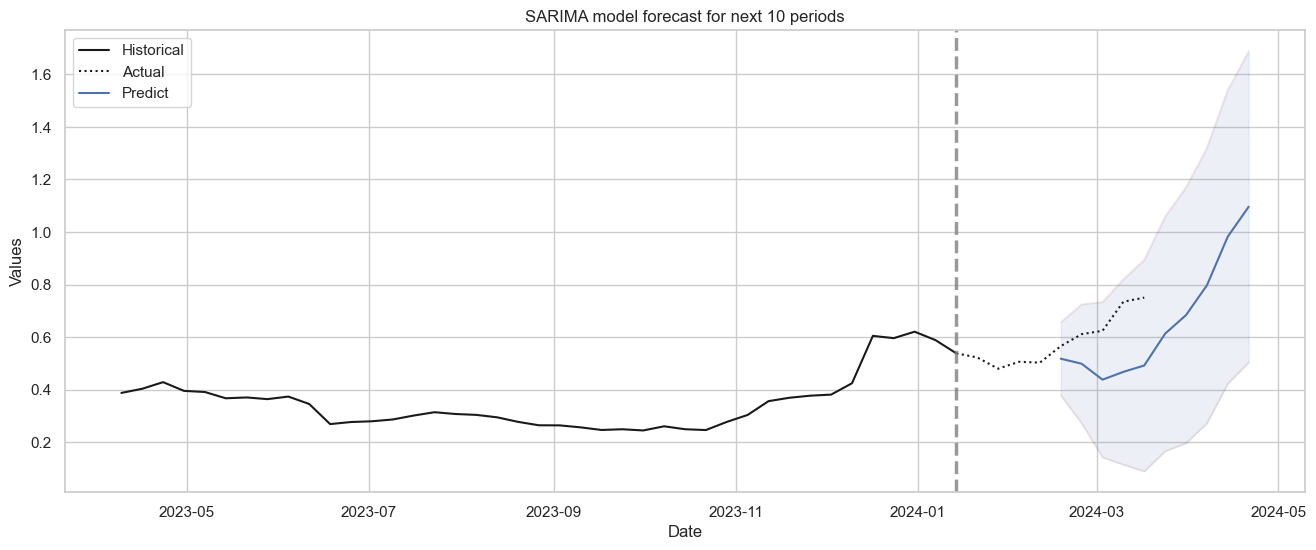

In [374]:
plot_forecast(model_fit, y_train, y, X_test, n_steps=10, plot_start_index= PLOT_START_INDEX)


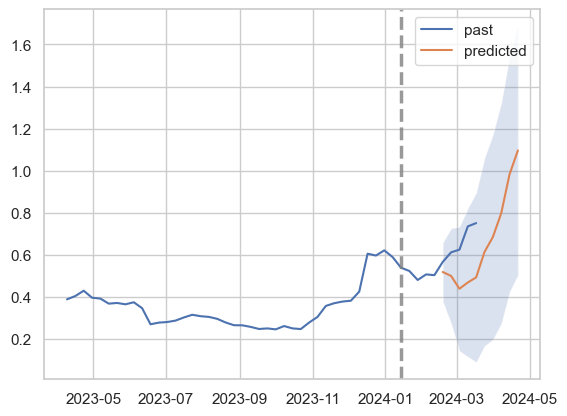

In [372]:
def plot_forecast(model_fit, y, X_test, n_steps=10, plot_start_index = -50):
    # Get forecast
    forecast_object = model_fit.get_forecast(steps=n_steps, exog=X_test)

    # Extract predicted mean attribute
    mean = forecast_object.predicted_mean

    # Calculate the confidence intervals
    conf_int = forecast_object.conf_int()

    # Extract the forecast dates
    dates = mean.index

    if plot_start_index:
        y = y[plot_start_index:]

    plt.figure()
    # Plot past levels
    plt.plot(y.index, y, label='past')
    # Plot the prediction means as line
    plt.plot(dates, mean, label='predicted')
    # Shade between the confidence intervals
    plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
    
    plt.axvline(x=y.index[-n_steps], c='gray', linewidth = 2.5, ls='--', alpha=0.8)

    # Plot legend and show figure
    plt.legend()
    plt.show()


# Call the function
plot_forecast(model_fit, y, X_test, n_steps=NUM_STEPS)
